In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
from scipy.io import wavfile 
import os

In [44]:
## Set parameters
text_filename = "test.txt"
audio_filename = "new.wav"

# Frequency encodings in Hz
low_freq = 512
high_freq = 2187 # Chose something that's coprime with low_freq 5103
gold_freq = 4375
gold_freq_2 = 1331 

fs = 44100 # Usually 44100 or 48000 fps 
t = 0.01
max_amp = 32767 # Because of signed 16 bit integers

## Generating Signal

In [63]:
### Import text and store as a string
contents = "" 
with open(text_filename, "r") as f: 
    contents = f.read() 
print("Contents as string: ", contents)

### Convert contents to binary string bin_contents 
# REPLACE WITH HUFFMAN
bin_contents = "".join(format(ord(c), '08b') for c in contents) #08b means 0 pad and 8 length

### Creating the "Sandwiche" Signal##
Flag =  '22222222'*5
bin_contents = Flag + bin_contents + Flag

print("Bit representation: ", bin_contents,)
print("Time to send: ", len(bin_contents) * t, "seconds")

# Generate wave 
wave = [] 
for b in bin_contents:
    if b == '0':
        freq = low_freq 
    elif b == '1':
        freq = high_freq 
    elif b == '2': 
        freq = gold_freq
    else:
        print('This should be 0 or 1 (or 2): ', b)    
    waveform = np.sin(2 * np.pi * freq * np.arange(t * fs) / fs) 
    waveform_ints = np.int16(max_amp * waveform)
    wave = np.append(wave, waveform_ints)
print("Wave shape: ", np.shape(wave))

Contents as string:  Hello abcdefghijklmnopqrstuvwxyz

Bit representation:  22222222222222222222222222222222222222220100100001100101011011000110110001101111001000000110000101100010011000110110010001100101011001100110011101101000011010010110101001101011011011000110110101101110011011110111000001110001011100100111001101110100011101010111011001110111011110000111100101111010000010102222222222222222222222222222222222222222
Time to send:  3.44 seconds
Wave shape:  (151704,)


In [46]:
wavfile.write(audio_filename, fs, wave.astype(np.dtype('i2')))

In [47]:
### DOESNT WORK ON MACOS I THINK - CHANGE TO SD.PLAY
os.system("aplay {}".format(audio_filename))

2

## Recording 

In [12]:
# Set parameters 
duration = 5 # seconds 

In [ ]:
# I'm using channels=1, most audio recording uses 2 channels because 
# of two headphone speakers (I think) but I think 1 channel is better 
# for plotting data

my_recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()
sd.stop()

print("Shape of recording data: ", np.shape(my_recording))

print('Done recording')

wavfile.write(filename, fs, my_recording)

# Make sure `python -m sounddevice` or `sd.query_devices()` says
# you're connected to both *in* and *out* channels. 

## Post-Processing

In [13]:
# Read the file - we'll have to change this to do while recording 
# SOURCE: https://pythondsp.rob-elder.com/loading-wav-files-and-showing-frequency-response/
sample_rate, data = wavfile.read(audio_filename) 
print("Sample rate (should be same as fs): ", sample_rate)
print("Data shape (should be 1-dimensional): ", data.shape)
samples = data.shape[0]

Sample rate (should be same as fs):  44100
Data shape (should be 1-dimensional):  (186984,)


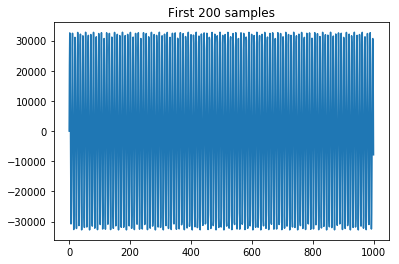

In [14]:
# Show first 200 samples 
plt.title("First 200 samples")
plt.plot(data[:1000])
plt.show()

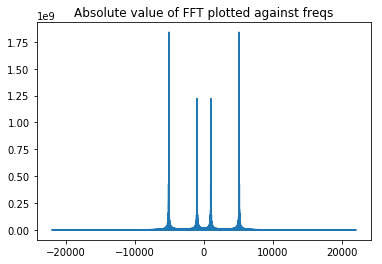

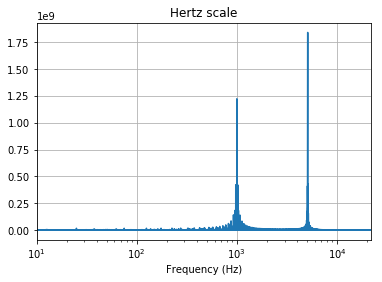

In [18]:
### This figures out frequencies for the *WHOLE* recording. 

data_fft = np.fft.fft(data)
fft_abs = abs(data_fft) 
freqs = np.fft.fftfreq(len(data), 1/fs)
plt.title("Absolute value of FFT plotted against freqs")
plt.plot(freqs, fft_abs)
plt.show() 

# Let's use a better scale: the log scale which shows freqs in Hertz 
plt.xlim([10, sample_rate/2]) 
plt.xscale('log')
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.title('Hertz scale')
# The original example used freqs[:int(freqs.size/2)] but I don't 
# think it matters
plt.plot(freqs, fft_abs)
plt.show()

### Aligning to .01 seconds

We start recording, **then start playing**, so that aligning should only get rid of noise. Our entire signal should be preserved. 

In [36]:
# Set parameters 
threshold_diff = 10
samp_per_chunk = int(t * fs) 

# Keeps shifting until we find a different in fft energy that meets 
# the threshold_diff
def find_start_index():
    start_index = 0
    highest_diff = 0
    end_index = 0
    for i in range(len(data)):
        # Compute fft for a chunk starting at the i'th sample
        chunk_fft = np.fft.fft(data[i:i+samp_per_chunk])
        chunk_fft_abs = abs(chunk_fft)
        
        # Compute mass of fft of 2 signal and then make sure it's higher than
        # the threshold_diff of the next highest thing
#         mass_0 = max(fft_abs[4:7])
#         mass_1 = max(fft_abs[20:23]) 
        mass_2 = max(fft_abs[42:45])
        fft_abs[42] = 0
        fft_abs[43] = 0 
        fft_abs[44] = 0 
        other_highest = max(fft_abs) 
        
        if start_index == 0 and abs(mass_2 - other_highest) > threshold_diff:
            start_index = i 
            highest_diff = abs(mass_2 - other_highest)
        if start_index != 0 and abs(mass_2 - other_highest) >= highest_diff:
            end_index = i
            highest_diff = abs(mass_2 - other_highest)
        else: # diff is decreasing so we were at max correlation  
            return end_index
        
#         if abs(mass_0 - mass_1) > threshold_diff:
#             return i

In [37]:
starting_index = find_start_index()

# Change data to reflect accurate starting index 
print('Starting index: ', starting_index)
print('Previous length: ', len(data))
data = data[starting_index:]
print('After length: ', len(data))

247168.2775520435
4663082.889452965
Starting index:  0
Previous length:  186984
After length:  186984


Length of each chunks:  441
Number of chunks (should be duration / t):  424
Make sure 0 bit freq is in between this:  [400. 500. 600.]
Make sure 1 bit freq is in between this:  [2000. 2100. 2200.]


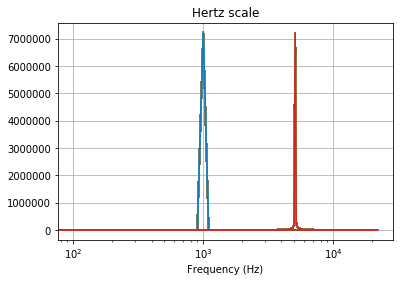

In [48]:
### This figures out frequencies for every interval of t seconds. 
### This is what we use to decode but it has to be perfectly 
### aligned with when the first signal starts. 

end = len(data)
chunks = [data[i:i + samp_per_chunk] 
          for i in range(starting_index, end, samp_per_chunk)]

print('Length of each chunks: ', samp_per_chunk)
print('Number of chunks (should be duration / t): ', len(chunks)) 

result_bit_string = ""
for i in range(len(chunks)): 
    chunk = chunks[i]
    c_fft = np.fft.fft(chunk)
    c_fft_abs = abs(c_fft)
    
    c_samples = chunk.shape[0]
    c_freqs = np.fft.fftfreq(c_samples, 1/sample_rate)
        
    ### Here's a potential problem: the c_freqs array here has each entry differ by 100
    # c_freqs[50:60] is [5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900] but 
    # in the whole sample (ie the freqs array 2 cells above) it differs by .2 
    ### Testing indices 
    if i == 0:
        mass_0_freqs = c_freqs[4:7]
        mass_1_freqs = c_freqs[20:23]
        print('Make sure 0 bit freq is in between this: ', mass_0_freqs)
        print('Make sure 1 bit freq is in between this: ', mass_1_freqs)
    
    mass_0 = max(c_fft_abs[4:7])
    mass_1 = max(c_fft_abs[20:23])
    mass_2 = max(c_fft_abs[42:45])
    
    #NEED TO ADD THRESHOLD 
    if mass_2 > mass_0 and mass_2 > mass_1:
        result_bit_string += '2' 
    elif mass_0 > mass_1: 
        result_bit_string += '0'
    elif mass_1 > mass_0:
        result_bit_string += '1'
    else: 
        print('None worked: ', mass_0, mass_1, mass_2)
    
    # FFT for every chunk
    plt.xscale('log')
    plt.grid(True)
    plt.xlabel('Frequency (Hz)')
    plt.title('Hertz scale')
    plt.plot(c_freqs, c_fft_abs)

In [59]:
### Now get rid of Gold code. Make sure to change any '2' 
### that isn't part of the Gold code section to a 1 or something 

# Test: 
# result_bit_string = '22222222222222222222222222222222222222010100201021010101010210101011101110012202222222222222222222'

l_result = list(result_bit_string)

# Remove Gold code prefix 
while l_result[0] == '2':
    l_result = l_result[1:]

# Remove Gold code suffix 
l_result = l_result[::-1]
while l_result[0] == '2':
    l_result = l_result[1:]
l_result = l_result[::-1]

# Change '2' in string to '1'
for i in range(len(l_result)):
    if l_result[i] == '2':
        l_result[i] = '1'

result_bit_string = "".join(l_result)

In [60]:
### Decode result_bit_string 

# Huffman decode eventually 
decoded_string = "" 
for i in range(0, len(result_bit_string), 8):
    decoded_string += chr(int(result_bit_string[i:i+8], 2))
print(decoded_string)

RµV®ç 
